Manipulate the original data to create modified datasets with: 

1. More/less site effect
2. More/less fixed effect (association with conversion)
3. More/less confounding effect

In [56]:
import sys
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:.03f}'.format

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from IPython.display import display

sys.path.append('../')
from medl.metrics import classification_metrics
from medl.models.lme import MixedGLMClassifier

In [53]:
dfData = pd.read_csv('../data/adni/baseline_features_24mo_imputeddx.csv', index_col=0)
dfTarget = pd.read_csv('../data/adni/target_24mo_imputeddx.csv', index_col=0)['0']

# Retain the 10 largest sites
dfSiteCount = dfData['SITE'].value_counts().sort_values(ascending=False)
top10Sites = dfSiteCount.index[:10]

dfData = dfData.loc[dfData['SITE'].isin(top10Sites)]
dfTarget = dfTarget.loc[dfData.index]

print(dfTarget.shape[0], 'subjects')
print('{:.01f}% conversion'.format(dfTarget.mean() * 100))

229 subjects
26.2% conversion


<AxesSubplot:xlabel='ADAS11_bl', ylabel='Count'>

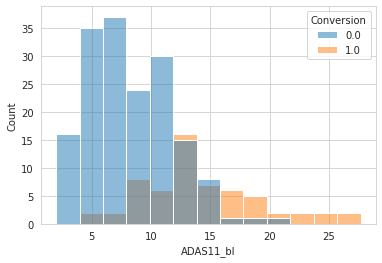

In [11]:
dfAdas11 = dfData[['ADAS11_bl']].copy()
dfAdas11['Conversion'] = dfTarget.loc[dfAdas11.index]
dfAdas11.dropna(inplace=True)

sns.histplot(data=dfAdas11, x='ADAS11_bl', hue='Conversion')

This function fits a Binomial Bayesian Mixed GLM classifier with site-specific slope, then prints the fitted coefficients and metrics.

In [60]:
def fit_model(dfX):
    model = MixedGLMClassifier('ADAS11_bl', 'Site', 'Conversion')
    model.fit(dfX)
    display(model.fit_result.summary())
    display(model.fit_result.random_effects())
    print('RE s.d.', model.fit_result.random_effects()['Mean'].std())

    arrPred = model.predict(dfX)
    dictMetrics, youden = classification_metrics(dfX['Conversion'], arrPred)
    dfMetrics = pd.Series(dictMetrics)
    display(dfMetrics)

    # Per-site accuracy
    arrSites = dfX['Site'].unique()
    arrSites = np.sort(arrSites)
    dictPerSite = {}
    for site in arrSites:
        dfSite = dfX.loc[dfX['Site'] == site]
        arrPredSite = model.predict(dfSite)
        dictPerSite[site] = classification_metrics(dfSite['Conversion'], arrPredSite, youden)[0]

    dfPerSite = pd.DataFrame(dictPerSite)
    display(dfPerSite)

    dfPerSiteT = dfPerSite.T
    dfPerSiteT['Site'] = dfPerSiteT.index
    dfPerSiteLong = pd.melt(dfPerSiteT, id_vars=['Site'], var_name='Metric', value_name='Value')

    bars = sns.barplot(data=dfPerSiteLong, x='Metric', y='Value')
    for tick in bars.get_xticklabels():
        tick.set_rotation(45)


## Original data

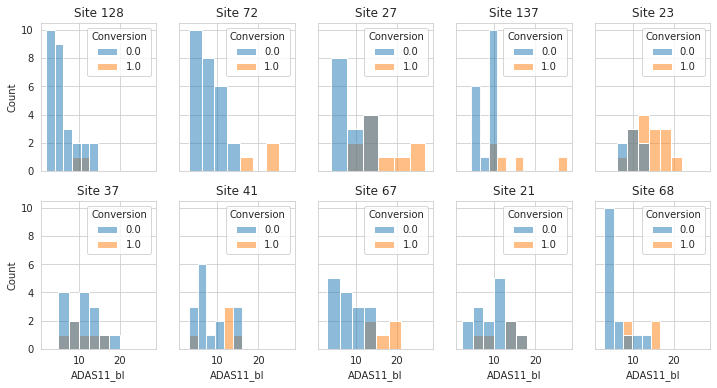

In [26]:
dfOrig = dfAdas11.copy()
dfOrig['Site'] = dfData['SITE'].loc[dfOrig.index]

fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(12, 6))

for iSite, site in enumerate(top10Sites):
    dfSite = dfOrig.loc[dfOrig['Site'] == site]
    sns.histplot(data=dfSite, x='ADAS11_bl', hue='Conversion', ax=ax.flatten()[iSite])
    ax.flatten()[iSite].set_title(f'Site {site}')

fig.show()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-4.4704,0.1854,,,
ADAS11_bl,M,0.3218,0.0159,,,
site_slope,V,-2.6244,0.2520,0.072,0.044,0.120


,Mean,SD
C(Site)[21]:ADAS11_bl,-0.023,0.039
C(Site)[23]:ADAS11_bl,0.096,0.037
C(Site)[27]:ADAS11_bl,0.025,0.036
C(Site)[37]:ADAS11_bl,-0.032,0.038
C(Site)[41]:ADAS11_bl,-0.007,0.041
C(Site)[67]:ADAS11_bl,-0.000,0.040
C(Site)[68]:ADAS11_bl,0.026,0.049
C(Site)[72]:ADAS11_bl,-0.058,0.039
C(Site)[128]:ADAS11_bl,-0.038,0.047
C(Site)[137]:ADAS11_bl,0.011,0.044


RE s.d. 0.043682443410491614


AUROC            0.868
Accuracy         0.820
Youden's index   0.595
F1               0.687
PPV              0.634
NPV              0.904
Sensitivity      0.750
Specificity      0.845
dtype: float64

,21,23,27,37,41,67,68,72,128,137
AUROC,0.680,0.824,0.887,0.494,0.693,0.960,0.933,1.000,0.893,0.882
Accuracy,0.750,0.727,0.720,0.619,0.800,0.850,0.842,1.000,0.900,0.909
Youden's index,0.400,0.219,0.500,0.067,0.600,0.800,0.433,1.000,-0.036,0.600
F1,0.545,0.824,0.720,0.333,0.667,0.769,0.571,1.000,0.000,0.750
PPV,0.500,0.737,0.600,0.333,0.571,0.625,0.667,1.000,0.000,1.000
NPV,0.857,0.667,0.900,0.733,0.923,1.000,0.875,1.000,0.931,0.895
Sensitivity,0.600,0.933,0.900,0.333,0.800,1.000,0.500,1.000,0.000,0.600
Specificity,0.800,0.286,0.600,0.733,0.800,0.800,0.933,1.000,0.964,1.000


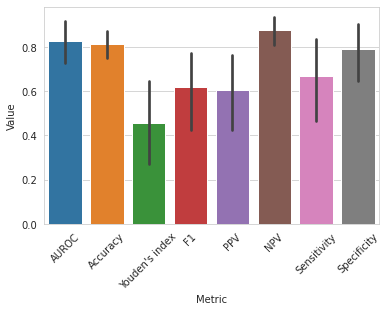

In [61]:
fit_model(dfOrig)

## Lower confounding effect and batch effect

Split the data into 10 "sites", stratified by ADAS11 score and class. This should yield sites with very similar distributions of both score and class, hence lower confounding effect and batch effect.

/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


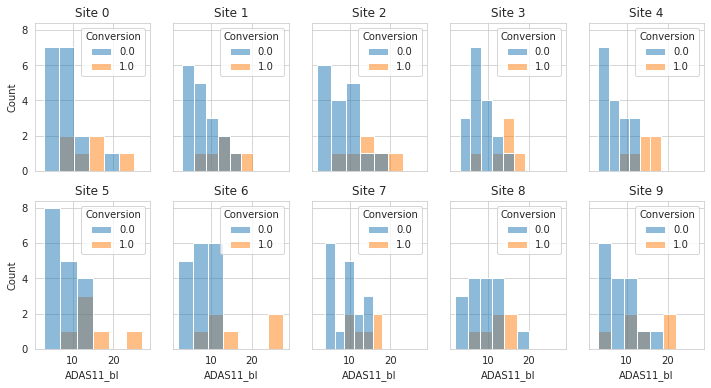

In [106]:
dfBins = pd.qcut(dfAdas11['ADAS11_bl'], 8, labels=False).astype(int)

lsStrata = [f'bin{d}_class{y}' for d, y in zip(dfBins, dfAdas11['Conversion'].astype(int))]
dfStrata = pd.Series(lsStrata, index=dfAdas11.index)

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=390)

fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(12, 6))
lsDeconfound = []
for iSite, (_, arrSiteIdx) in enumerate(splitter.split(dfAdas11, dfStrata)):
    dfSite = dfAdas11.iloc[arrSiteIdx].copy()
    dfSite['Site'] = iSite
    lsDeconfound += [dfSite]

    sns.histplot(data=dfSite, x='ADAS11_bl', hue='Conversion', ax=ax.flatten()[iSite])
    ax.flatten()[iSite].set_title(f'Site {iSite}')

dfDeconfound = pd.concat(lsDeconfound, axis=0)
plt.show()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-4.4393,0.1793,,,
ADAS11_bl,M,0.3231,0.0154,,,
site_slope,V,-3.2775,0.2631,0.038,0.022,0.064


,Mean,SD
C(Site)[0]:ADAS11_bl,-0.002,0.029
C(Site)[1]:ADAS11_bl,0.003,0.029
C(Site)[2]:ADAS11_bl,-0.001,0.028
C(Site)[3]:ADAS11_bl,0.006,0.028
C(Site)[4]:ADAS11_bl,0.008,0.029
C(Site)[5]:ADAS11_bl,0.000,0.028
C(Site)[6]:ADAS11_bl,-0.000,0.029
C(Site)[7]:ADAS11_bl,-0.004,0.028
C(Site)[8]:ADAS11_bl,-0.006,0.028
C(Site)[9]:ADAS11_bl,-0.004,0.029


RE s.d. 0.004584420082236696


AUROC            0.841
Accuracy         0.811
Youden's index   0.551
F1               0.661
PPV              0.627
NPV              0.888
Sensitivity      0.700
Specificity      0.851
dtype: float64

,0,1,2,3,4,5,6,7,8,9
AUROC,0.814,0.828,0.877,0.912,0.917,0.882,0.892,0.809,0.719,0.760
Accuracy,0.826,0.783,0.870,0.913,0.783,0.783,0.826,0.783,0.773,0.773
Youden's index,0.549,0.490,0.716,0.775,0.490,0.598,0.549,0.490,0.479,0.375
F1,0.667,0.615,0.769,0.833,0.615,0.667,0.667,0.615,0.615,0.545
PPV,0.667,0.571,0.714,0.833,0.571,0.556,0.667,0.571,0.571,0.600
NPV,0.882,0.875,0.938,0.941,0.875,0.929,0.882,0.875,0.867,0.824
Sensitivity,0.667,0.667,0.833,0.833,0.667,0.833,0.667,0.667,0.667,0.500
Specificity,0.882,0.824,0.882,0.941,0.824,0.765,0.882,0.824,0.812,0.875


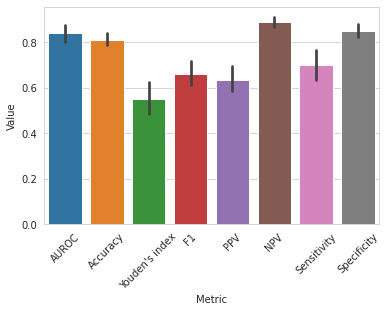

In [107]:
fit_model(dfDeconfound)

## Higher confounding effect

Increase the association between ADAS11 and conversion as a function of site membership.

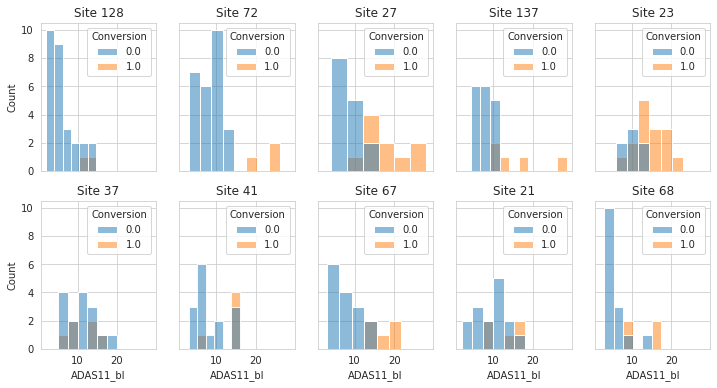

In [130]:
# def distance_from_line(args):
#     x, y = args
#     # FE coefficients from previous model
#     m = 0.323
#     b = -4.439
#     ylinear = m * x + b
#     # sigmoid
#     yhat = 1 / (1 + np.exp(-ylinear))
#     return np.abs(yhat - y)
        
# dfDistance = dfAdas11.apply(distance_from_line, axis=1, raw=True)
# dfHighConfound = dfAdas11.copy()

# dfHighConfound['Site'] = pd.qcut(dfDistance, 10, labels=False)

dfHighConfound = dfOrig.copy()
dfSiteCount = dfHighConfound['Site'].value_counts() / dfHighConfound.shape[0]
for i, row in dfHighConfound.iterrows():
    if row['Conversion'] == 1:
        dfHighConfound.loc[i, 'ADAS11_bl'] = row['ADAS11_bl'] + 10 * dfSiteCount[row['Site']]

fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(12, 6))

for iSite, site in enumerate(top10Sites):
    dfSite = dfHighConfound.loc[dfHighConfound['Site'] == site]
    sns.histplot(data=dfSite, x='ADAS11_bl', hue='Conversion', ax=ax.flatten()[iSite])
    ax.flatten()[iSite].set_title(f'Site {site}')

fig.show()

# dfDistance = dfDistance.to_frame('Distance')
# dfDistance['Site'] = dfData['SITE'].loc[dfAdas11.index]
# sns.histplot(data=dfDistance, x='Distance', hue='Site', kde=True, palette='Set1')

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-5.1247,0.1946,,,
ADAS11_bl,M,0.3699,0.0161,,,
site_slope,V,-2.6466,0.2523,0.071,0.043,0.117


,Mean,SD
C(Site)[21]:ADAS11_bl,-0.021,0.039
C(Site)[23]:ADAS11_bl,0.089,0.037
C(Site)[27]:ADAS11_bl,0.022,0.036
C(Site)[37]:ADAS11_bl,-0.030,0.037
C(Site)[41]:ADAS11_bl,-0.007,0.040
C(Site)[67]:ADAS11_bl,-0.003,0.040
C(Site)[68]:ADAS11_bl,0.027,0.049
C(Site)[72]:ADAS11_bl,-0.061,0.040
C(Site)[128]:ADAS11_bl,-0.031,0.046
C(Site)[137]:ADAS11_bl,0.017,0.044


RE s.d. 0.041609350565147404


AUROC            0.898
Accuracy         0.864
Youden's index   0.655
F1               0.744
PPV              0.738
NPV              0.910
Sensitivity      0.750
Specificity      0.905
dtype: float64

,21,23,27,37,41,67,68,72,128,137
AUROC,0.720,0.886,0.940,0.533,0.720,1.000,0.933,1.000,0.911,0.941
Accuracy,0.850,0.818,0.880,0.667,0.800,0.900,0.842,1.000,0.900,0.909
Youden's index,0.533,0.505,0.767,0.133,0.600,0.867,0.433,1.000,-0.036,0.600
F1,0.667,0.875,0.857,0.364,0.667,0.833,0.571,1.000,0.000,0.750
PPV,0.750,0.824,0.818,0.400,0.571,0.714,0.667,1.000,0.000,1.000
NPV,0.875,0.800,0.929,0.750,0.923,1.000,0.875,1.000,0.931,0.895
Sensitivity,0.600,0.933,0.900,0.333,0.800,1.000,0.500,1.000,0.000,0.600
Specificity,0.933,0.571,0.867,0.800,0.800,0.867,0.933,1.000,0.964,1.000


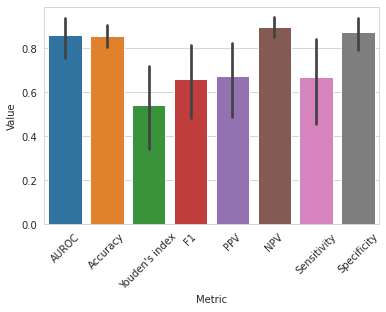

In [131]:
fit_model(dfHighConfound)

## Higher batch effect (without confounding effect)

Group samples such that each site has a different distribution of ADAS11 but the same class distribution.

/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

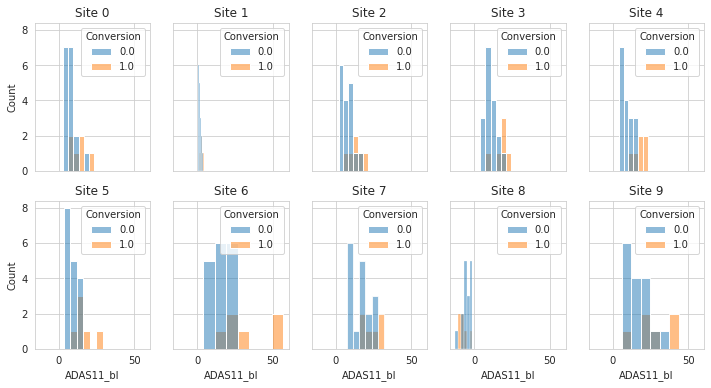

In [115]:
# Multiply an additional slope to each site
arrSlopes = np.random.randn(10) * 0.5

dfHighBatch = dfDeconfound.copy()
for iSite in range(10):
    dfHighBatch['ADAS11_bl'].loc[dfHighBatch['Site'] == iSite] *= (1 + arrSlopes[iSite])

fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(12, 6))

for iSite in range(10):
    dfSite = dfHighBatch.loc[dfHighBatch['Site'] == iSite]
    sns.histplot(data=dfSite, x='ADAS11_bl', hue='Conversion', ax=ax.flatten()[iSite])
    ax.flatten()[iSite].set_title(f'Site {iSite}')

fig.show()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-3.6787,0.1730,,,
ADAS11_bl,M,0.2136,0.0110,,,
site_slope,V,-1.1199,0.2309,0.326,0.206,0.518


,Mean,SD
C(Site)[0]:ADAS11_bl,0.056,0.050
C(Site)[1]:ADAS11_bl,0.664,0.182
C(Site)[2]:ADAS11_bl,0.066,0.049
C(Site)[3]:ADAS11_bl,0.001,0.036
C(Site)[4]:ADAS11_bl,0.009,0.037
C(Site)[5]:ADAS11_bl,0.029,0.043
C(Site)[6]:ADAS11_bl,-0.087,0.023
C(Site)[7]:ADAS11_bl,-0.073,0.024
C(Site)[8]:ADAS11_bl,-0.574,0.074
C(Site)[9]:ADAS11_bl,-0.086,0.024


RE s.d. 0.298168936547604


AUROC            0.784
Accuracy         0.803
Youden's index   0.496
F1               0.628
PPV              0.623
NPV              0.868
Sensitivity      0.633
Specificity      0.863
dtype: float64

/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6,7,8,9
AUROC,0.814,0.828,0.877,0.912,0.917,0.882,0.892,0.809,0.719,0.760
Accuracy,0.826,0.739,0.870,0.826,0.826,0.783,0.870,0.783,0.773,0.727
Youden's index,0.549,0.000,0.716,0.657,0.657,0.598,0.716,0.490,0.271,0.312
F1,0.667,0.000,0.769,0.714,0.714,0.667,0.769,0.615,0.444,0.500
PPV,0.667,0.000,0.714,0.625,0.625,0.556,0.714,0.571,0.667,0.500
NPV,0.882,0.739,0.938,0.933,0.933,0.929,0.938,0.875,0.789,0.812
Sensitivity,0.667,0.000,0.833,0.833,0.833,0.833,0.833,0.667,0.333,0.500
Specificity,0.882,1.000,0.882,0.824,0.824,0.765,0.882,0.824,0.938,0.812


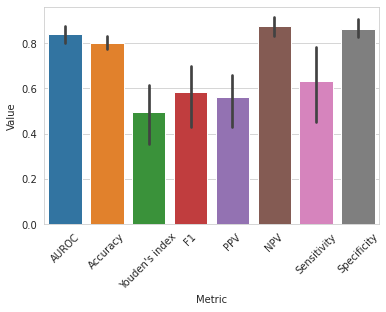

In [116]:
fit_model(dfHighBatch)

## Higher fixed effect size

Create a linear function $f(x, y)$ of the variable $x$ and the class $y$, then add this to $x$ to increase the association between $x$ and $y$: $\hat{x} = x + f(x, y)$.

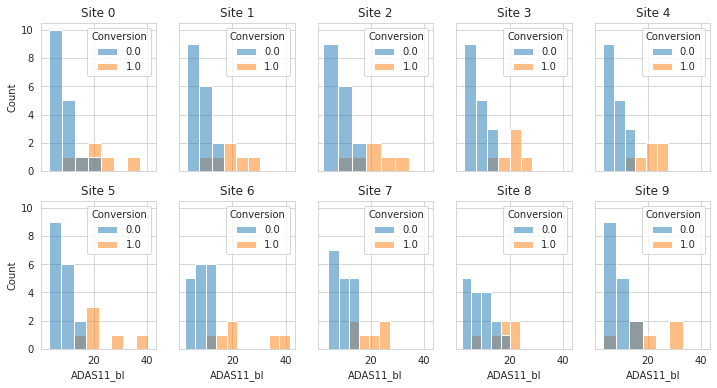

In [120]:
dfHighEffect = dfDeconfound.copy()

effect = lambda x, y: 0.5 * y * x

dfHighEffect['ADAS11_bl'] += effect(dfHighEffect['ADAS11_bl'], dfHighEffect['Conversion'])

fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(12, 6))

for iSite in range(10):
    dfSite = dfHighEffect.loc[dfHighEffect['Site'] == iSite]
    sns.histplot(data=dfSite, x='ADAS11_bl', hue='Conversion', ax=ax.flatten()[iSite])
    ax.flatten()[iSite].set_title(f'Site {iSite}')

fig.show()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-6.7316,0.2405,,,
ADAS11_bl,M,0.4474,0.0176,,,
site_slope,V,-3.1673,0.2611,0.042,0.025,0.071


,Mean,SD
C(Site)[0]:ADAS11_bl,-0.000,0.033
C(Site)[1]:ADAS11_bl,0.006,0.032
C(Site)[2]:ADAS11_bl,-0.004,0.032
C(Site)[3]:ADAS11_bl,0.003,0.033
C(Site)[4]:ADAS11_bl,0.006,0.033
C(Site)[5]:ADAS11_bl,0.000,0.032
C(Site)[6]:ADAS11_bl,0.004,0.033
C(Site)[7]:ADAS11_bl,-0.005,0.031
C(Site)[8]:ADAS11_bl,-0.009,0.032
C(Site)[9]:ADAS11_bl,-0.001,0.032


RE s.d. 0.004943982864402862


AUROC            0.959
Accuracy         0.912
Youden's index   0.795
F1               0.839
PPV              0.812
NPV              0.951
Sensitivity      0.867
Specificity      0.929
dtype: float64

,0,1,2,3,4,5,6,7,8,9
AUROC,0.956,0.961,0.980,0.990,1.000,0.990,0.980,0.961,0.875,0.906
Accuracy,0.913,0.913,0.870,0.913,1.000,0.957,0.957,0.826,0.909,0.864
Youden's index,0.775,0.775,0.716,0.775,1.000,0.941,0.833,0.657,0.771,0.708
F1,0.833,0.833,0.769,0.833,1.000,0.923,0.909,0.714,0.833,0.769
PPV,0.833,0.833,0.714,0.833,1.000,0.857,1.000,0.625,0.833,0.714
NPV,0.941,0.941,0.938,0.941,1.000,1.000,0.944,0.933,0.938,0.933
Sensitivity,0.833,0.833,0.833,0.833,1.000,1.000,0.833,0.833,0.833,0.833
Specificity,0.941,0.941,0.882,0.941,1.000,0.941,1.000,0.824,0.938,0.875


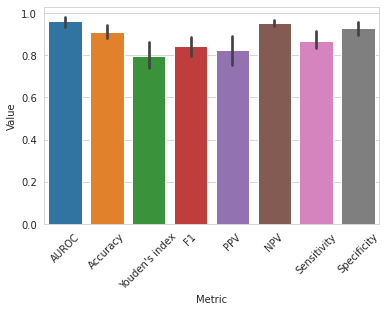

In [121]:
fit_model(dfHighEffect)